# MACHINE LEARNING CAPSTONE PROJECT:  
### TOXIC COMMENT CLASSIFICATION 

1. Import necessary files <br/>
2. Read the train.csv file <br/>
3. List the various fields in our dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
#Read the csv file into dataframe df
df = pd.read_csv("train.csv")
print(df.shape)

(95851, 8)


In [10]:
#List the fields in our dataframe
print(df.dtypes)

id                int64
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


Hence we have a sufficiently large dataset consistly of 95851 samples. Each sample contains 8 fields. <br/>
**It was observed that running train_test_split on the heavy preprocessed dataframe sometimes resulted in system going out of memory. Hence to avoid such cases, one extra line of code was added. The df.reindex code will shuffle the indices initially, so that later splitting dataset into training and testing will give fairer results.**

In [11]:
# below line causes shuffling of indices, to avoid using train_test_split later
df = df.reindex(np.random.permutation(df.index))

# Separate the comment field data and outcome labels

In [16]:
comment = df['comment_text']
print(comment.head())
comment = comment.as_matrix()

0    Nonsense?  kiss off, geek. what I said is true...
1    "\n\n Please do not vandalize pages, as you di...
2    "\n\n ""Points of interest"" \n\nI removed the...
3    Asking some his nationality is a Racial offenc...
4    The reader here is not going by my say so for ...
Name: comment_text, dtype: object


In [17]:
label = df[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
print(label.head())
label = label.as_matrix()

   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      1             0        0       0       0              0
1      0             0        0       0       0              0
2      0             0        0       0       0              0
3      0             0        0       0       0              0
4      0             0        0       0       0              0


### Let us find out the frequency of occurence of multilabelled data 
- ct1 counts samples having atleast one label
- ct2 counts samples having 2 or more than 2 labels

In [18]:
ct1,ct2 = 0,0
for i in range(label.shape[0]):
    ct = np.count_nonzero(label[i])
    if ct :
        ct1 = ct1+1
    if ct>1 :
        ct2 = ct2+1
print(ct1)
print(ct2)

9790
5957


## Data Visualisations
### Let us analyse the no. of comments having lengths varying from 0 to 1200

average length of comment: 395.342


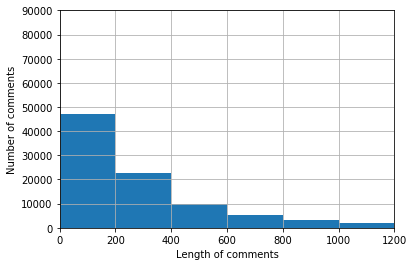

In [7]:
x = [len(comment[i]) for i in range(comment.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,200,400,600,800,1000,1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

### Number of comments classified as toxic,severe_toxic,....etc depending on their lengths

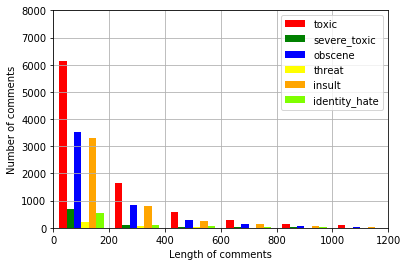

In [8]:
y = np.zeros(label.shape)
for ix in range(comment.shape[0]):
    l = len(comment[ix])
    if label[ix][0] :
        y[ix][0] = l
    if label[ix][1] :
        y[ix][1] = l
    if label[ix][2] :
        y[ix][2] = l
    if label[ix][3] :
        y[ix][3] = l
    if label[ix][4] :
        y[ix][4] = l
    if label[ix][5] :
        y[ix][5] = l

labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']        
plt.hist(y,bins = bins,label = labelsplt,color = color)
plt.axis([0, 1200, 0, 8000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

### Remove excessive length comments
Some very large length comments can be seen, in our dataset. These pose serious problems like adding excessively more words to the training dataset, causing training time to increase and accuracy to decrease!<br/>
Hence, a threshold of 400 characters will be created and only comments which have length smaller than 400 will be used further.

In [9]:
comments = []
labels = []

for ix in range(comment.shape[0]):
    if len(comment[ix])<=400:
        comments.append(comment[ix])
        labels.append(label[ix])

In [10]:
labels = np.asarray(labels)

In [11]:
print(len(comments))

69627


Hence, after removing comments longer than 400 characters, we are still left with more than 69000 comments, which seems enough for training purposes.

# Preprocessing 
Preprocessing involved the following steps, but these will be performed in a slightly different manner:
- Removing Punctuations and other special characters
- Splitting the comments into individual words
- Removing Stop Words
- Stemming and Lemmatising
- Applying Count Vectoriser
- Splitting dataset into Training and Testing

## Preparing a string containing all punctuations to be removed
The string library contains punctuation characters. This is imported and all numbers are appended to this string. Also, we can notice that our comment_text field contains strings such as won't, didn't, etc which contain apostrophe character('). To prevent these words from being converted to wont/didnt, the character ' represented as \' in escape sequence notation is replaced by empty character in the punctuation string. <br/>

**maketrans()** returns a translation table that maps each character in the punctuation_edit into the character at the same position in the outtab string i.e. it replaces every character in the removal list with a space, since outtab contains a string with spaces.

In [12]:
import string
print(string.punctuation)
punctuation_edit = string.punctuation.replace('\'','') +"0123456789"
print (punctuation_edit)
outtab = "                                         "
trantab = str.maketrans(punctuation_edit, outtab)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789


## Updating the list of stop words
**Stop words** are those words that are frequently used in both written and verbal communication and thereby do not have either a positive/negative impact on our statement.E.g. is, this, us,etc. <br/>
Single letter words if existing or created due to any preprocessing step do not convey any useful meaning and hence can be directly removed. Hence letters from b to z, will be added to the list of stop words imported directly.

In [13]:
from stop_words import get_stop_words
stop_words = get_stop_words('english')
stop_words.append('')

for x in range(ord('b'), ord('z')+1):
    stop_words.append(chr(x))

In [14]:
print (stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

## Stemming and Lemmatizing
**Stemming** is the process of converting inflected/derived words to their word stem or the root form. Basically, a large number of similar origin words are converted to the same word.E.g. words like "stems", "stemmer", "stemming", "stemmed" as based on "stem". This helps in achieving the training process with a better accuracy.<br/>
**Lemmatizing** is the process of grouping together the inflected forms of a word so they can be analysed as a single item. This is quite similar to stemming in its working but differs since it depends on correctly identifying the intended part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence, such as neighboring sentences or even an entire document.<br/>
The **wordnet library in nltk** will be used for this purpose. Stemmer and Lemmatizer are also imported from nltk.


In [15]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [16]:
#create objects for stemmer and lemmatizer
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deeptibaghel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### We can now, loop once through all the comments applying :
- punctuation removal
- splitting the words by space
- applying stemmer and lemmatizer
- recombining the words again for further processing

In [17]:
for i in range(len(comments)):
    comments[i] = comments[i].lower().translate(trantab)
    l = []
    for word in comments[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    comments[i] = " ".join(l)

## Applying Count Vectorizer
Here we can finally convert our comments into a matrix of token counts, which signifies the number of times it occurs.

In [18]:
#import required library
from sklearn.feature_extraction.text import CountVectorizer

#create object supplying our custom stop words
count_vector = CountVectorizer(stop_words=stop_words)
#fitting it to converts comments into bag of words format
tf = count_vector.fit_transform(comments).toarray()

In [19]:
# print(count_vector.get_feature_names())
print(tf.shape)

(69627, 52905)


Hence from its shape we can imply that after all preprocessing we have a list of 52905 words in total.
## Splitting dataset into training and testing
- Since the system was going out of memory using train_test_split, I had jumbled all the indexes in the beginning itself. 
- The shuffle function defined here performs the task of assigning first 2/3rd values to train and remaining 1/3rd values to the test set.

In [20]:
def shuffle(matrix, target, test_proportion):
    ratio = int(matrix.shape[0]/test_proportion)
    X_train = matrix[ratio:,:]
    X_test =  matrix[:ratio,:]
    Y_train = target[ratio:,:]
    Y_test =  target[:ratio,:]
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = shuffle(tf, labels,3)

print(X_test.shape)
print(X_train.shape)

(23209, 52905)
(46418, 52905)


# Implementation :
### Let us define all the evaluation metrics

In [21]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

## Starting with the First Model -
### Problem Transformation Methods :
**These include the Binary Relevance, Label Powerset and Classifier Chain methods. Implementations of these methods is available in the scikit-multilearn library. **
- I will be implementing the most basic method,which is the **Binary Relevance** method from scratch. It does not take into account the interdependence of labels and basically creates a separate classifier for each of the labels.
- Scikit-multilearn library's classifier will also be imported and tested with different classifiers to observe if it gives similar results.

### 1. Binary Relevance (BR) Method with MultinomialNB classifiers (from scratch)

In [22]:
from sklearn.naive_bayes import MultinomialNB

In [70]:
# clf will be the list of the classifiers for all the 6 labels
# each classifier is fit with the training data and corresponding classifier
clf = []
for ix in range(6):
    clf.append(MultinomialNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [71]:
# predict list contains the predictions, it is transposed later to get the proper shape
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

predict = np.asarray(np.transpose(predict))
print(predict.shape)

(23209, 6)


In [72]:
# calculate results
evaluate_score(Y_test,predict)

Hamming_loss : 3.2796185387852415
Accuracy : 88.29764315567236
Log_loss : 1.9296193554647956


### 2. BR Method with SVM classifier (from scikit-multilearn)

In [61]:
#create and fit classifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
classifier = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier.fit(X_train, Y_train)

BinaryRelevance(classifier=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
        require_dense=[False, True])

In [62]:
#predictions
predictions = classifier.predict(X_test)

In [68]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 4.26702285033105
Accuracy : 88.276099788875
Log_loss : 0.4616701016298293


### 3. BR Method with Multinomial classifier (from scikit-multilearn)

In [73]:
#create and fit classifier
classifier = BinaryRelevance(classifier = MultinomialNB(), require_dense = [False, True])
classifier.fit(X_train, Y_train)

BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        require_dense=[False, True])

In [74]:
#predictions
predictions = classifier.predict(X_test)

In [75]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 3.2796185387852415
Accuracy : 88.29764315567236
Log_loss : 1.9296193554647956


### 4. BR Method with GausseanNB classifier (from scratch)

In [78]:
from sklearn.naive_bayes import GaussianNB
#create and fit classifiers
clf = []
for ix in range(6):
    clf.append(GaussianNB())
    clf[ix].fit(X_train,Y_train[:,ix])

In [79]:
#predictions
predict = []
for ix in range(6):
    predict.append(clf[ix].predict(X_test))

In [80]:
#calculate scores
predict = np.asarray(np.transpose(predict))
evaluate_score(Y_test,predict)

Hamming_loss : 20.746262225860658
Accuracy : 52.199577750010775
Log_loss : 1.4227365989183884


### 5. Classifier chain with MultinomialNB classifier (from scikit-multilearn)

In [23]:
#create and fit classifier
from skmultilearn.problem_transform import ClassifierChain
classifier = ClassifierChain(MultinomialNB())
classifier.fit(X_train, Y_train)

ClassifierChain(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
        require_dense=[True, True])

In [24]:
#predictions
predictions = classifier.predict(X_test)

In [ ]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 3.5647090927370133
Accuracy : 88.25886509543712
Log_loss : 1.506849253150214


### 6. Label Powerset with MultinomialNB classifier (from scikit-multilearn)

In [24]:
#create and fit classifier
from skmultilearn.problem_transform import LabelPowerset
classifier = LabelPowerset(MultinomialNB())
classifier.fit(X_train, Y_train)

LabelPowerset(classifier=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       require_dense=[True, True])

In [25]:
#predictions
predictions = classifier.predict(X_test)

In [26]:
#calculate scores
evaluate_score(Y_test,predictions)

Hamming_loss : 3.1726198170250046
Accuracy : 88.80606661209013
Log_loss : 1.4765486777963348


## Adaptation Algorithms
### 7. MLkNN  with k=2 (from scikit-multilearn)
This is the adapted multi-label version of K Nearest Neighbours. Its implementation is available in the multilearn library.

In [ ]:
#create and fit classifier
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=2)
classifier.fit(X_train, Y_train)

In [ ]:
#predictions
predictions = classifier.predict(X_test)

In [ ]:
#calculate scores
evaluate_score(Y_test,predictions)

### 8. BP-MLL Neural Networks (from scratch)

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

In [29]:
#define model architecture
model = Sequential()
model.add(Dense(4, activation='relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 211956    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 30        
Total params: 211,986
Trainable params: 211,986
Non-trainable params: 0
_________________________________________________________________


In [30]:
#compile model with all parameters set
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
#Fit using check pointer
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.myneural.h5py', 
                               verbose=1, save_best_only=True)
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
46418/46418 [==============================] - 60s 1ms/step - loss: 0.3684 - acc: 0.9419
Epoch 2/10
46418/46418 [==============================] - 60s 1ms/step - loss: 0.3489 - acc: 0.9901
Epoch 3/10
46418/46418 [==============================] - 62s 1ms/step - loss: 0.3449 - acc: 0.9906
Epoch 4/10
46418/46418 [==============================] - 59s 1ms/step - loss: 0.3425 - acc: 0.9888: 0s - loss: 0.3424 - acc: 0.98
Epoch 5/10
46418/46418 [==============================] - 59s 1ms/step - loss: 0.3424 - acc: 0.9876
Epoch 6/10
46418/46418 [==============================] - 58s 1ms/step - loss: 0.3424 - acc: 0.9879
Epoch 7/10
46418/46418 [==============================] - 57s 1ms/step - loss: 0.3414 - acc: 0.9868
Epoch 8/10
46418/46418 [==============================] - 60s 1ms/step - loss: 0.3404 - acc: 0.9851
Epoch 9/10
46418/46418 [==============================] - 61s 1ms/step - loss: 0.3402 - acc: 0.9846
Epoch 10/10
46418/46418 [==============================] - 61s 1ms/st

In [33]:
#predictions
predict = model.predict(X_test)

In [37]:
print(predict[0])

[  6.69890046e-01   9.70017936e-05   1.44642159e-01   1.16227047e-05
   1.78119496e-01   7.23966770e-03]


**Since the results returned by the model are in the form of probabilities, they have to be explicitly converted to either 0/1 using the round function. This is because the hamming_loss and accuracy_score cannot work on these values directly. However, log loss can compute loss directly without modifying the values.**

In [38]:
#calculate score
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))

Log_loss : 0.36017768848519677
Hamming_loss : 13.960101684691285
Accuracy : 29.52302985910638


## Let us try improving the BP-MLL model (Refining)


In [35]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import optimizers

#define parameters for using in param grid
nodes = [16, 32, 64] # number of nodes in the hidden layer
lrs = [0.001, 0.002, 0.003] # learning rate, default = 0.001
epochs = [10,20,30]
batch_size = 64

In [36]:
def create_model(nodes=10,lr=0.001):
    model = Sequential()
    model.add(Dense(nodes, activation='relu', input_dim = X_train.shape[1]))
    model.add(Dropout(0.3))
    model.add(Dense(6, activation='softmax'))
    opt = optimizers.RMSprop(lr=lr)
    model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model)

In [37]:
#start fitting process
param_grid = dict(epochs=epochs,nodes=nodes, lr=lrs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,refit=True,verbose=2)
grid_result = grid.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] epochs=10, lr=0.001, nodes=16 ...................................
Epoch 1/10
30945/30945 [==============================] - 39s 1ms/step - loss: 0.3682 - acc: 0.9536
Epoch 2/10
30945/30945 [==============================] - 27s 878us/step - loss: 0.3440 - acc: 0.9794
Epoch 3/10
30945/30945 [==============================] - 25s 820us/step - loss: 0.3379 - acc: 0.9786
Epoch 4/10
30945/30945 [==============================] - 26s 837us/step - loss: 0.3324 - acc: 0.9745
Epoch 5/10
30945/30945 [==============================] - 26s 832us/step - loss: 0.3280 - acc: 0.9718
Epoch 6/10
30945/30945 [==============================] - 26s 842us/step - loss: 0.3249 - acc: 0.9688
Epoch 7/10
30945/30945 [==============================] - 27s 878us/step - loss: 0.3227 - acc: 0.9654
Epoch 8/10
30945/30945 [==============================] - 26s 838us/step - loss: 0.3202 - acc: 0.9647
Epoch 9/10
30945/30945 [==============================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s


Epoch 1/10
30945/30945 [==============================] - 33s 1ms/step - loss: 0.3783 - acc: 0.9584
Epoch 2/10
30945/30945 [==============================] - 22s 715us/step - loss: 0.3515 - acc: 0.9802
Epoch 3/10
30945/30945 [==============================] - 22s 706us/step - loss: 0.3447 - acc: 0.9793
Epoch 4/10
30945/30945 [==============================] - 23s 731us/step - loss: 0.3407 - acc: 0.9788
Epoch 5/10
30945/30945 [==============================] - 23s 733us/step - loss: 0.3373 - acc: 0.9770
Epoch 6/10
30945/30945 [==============================] - 22s 726us/step - loss: 0.3342 - acc: 0.9748
Epoch 7/10
30945/30945 [==============================] - 22s 713us/step - loss: 0.3312 - acc: 0.9697
Epoch 8/10
30945/30945 [==============================] - 22s 695us/step - loss: 0.3303 - acc: 0.9648
Epoch 9/10
30945/30945 [==============================] - 22s 702us/step - loss: 0.3280 - acc: 0.9621
Epoch 10/10
30945/30945 [==============================] - 20s 657us/step
[CV] .....

30945/30945 [==============================] - 24s 770us/step
[CV] .................... epochs=10, lr=0.002, nodes=32, total= 6.6min
[CV] epochs=10, lr=0.002, nodes=32 ...................................
Epoch 1/10
30946/30946 [==============================] - 45s 1ms/step - loss: 0.3548 - acc: 0.9814
Epoch 2/10
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3352 - acc: 0.9780
Epoch 3/10
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3259 - acc: 0.9722
Epoch 4/10
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3205 - acc: 0.9696
Epoch 5/10
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3160 - acc: 0.9651
Epoch 6/10
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3119 - acc: 0.9607
Epoch 7/10
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3099 - acc: 0.9561
Epoch 8/10
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3047 - acc: 0.9

30946/30946 [==============================] - 54s 2ms/step - loss: 0.3025 - acc: 0.9366
Epoch 9/10
30946/30946 [==============================] - 54s 2ms/step - loss: 0.3007 - acc: 0.9303
Epoch 10/10
30946/30946 [==============================] - 24s 778us/step
[CV] .................... epochs=10, lr=0.003, nodes=64, total=10.0min
[CV] epochs=20, lr=0.001, nodes=16 ...................................
Epoch 1/20
30945/30945 [==============================] - 35s 1ms/step - loss: 0.3706 - acc: 0.9596
Epoch 2/20
30945/30945 [==============================] - 23s 734us/step - loss: 0.3420 - acc: 0.9811
Epoch 3/20
30945/30945 [==============================] - 22s 700us/step - loss: 0.3362 - acc: 0.9808
Epoch 4/20
30945/30945 [==============================] - 23s 733us/step - loss: 0.3320 - acc: 0.9792
Epoch 5/20
30945/30945 [==============================] - 23s 733us/step - loss: 0.3284 - acc: 0.9772
Epoch 6/20
30945/30945 [==============================] - 23s 739us/step - loss: 0.3237

30945/30945 [==============================] - 24s 783us/step
[CV] .................... epochs=20, lr=0.001, nodes=64, total=18.5min
[CV] epochs=20, lr=0.001, nodes=64 ...................................
Epoch 1/20
30945/30945 [==============================] - 65s 2ms/step - loss: 0.3652 - acc: 0.9787
Epoch 2/20
30945/30945 [==============================] - 54s 2ms/step - loss: 0.3437 - acc: 0.9787
Epoch 3/20
30945/30945 [==============================] - 53s 2ms/step - loss: 0.3337 - acc: 0.9731
Epoch 4/20
30945/30945 [==============================] - 53s 2ms/step - loss: 0.3279 - acc: 0.9686
Epoch 5/20
30945/30945 [==============================] - 52s 2ms/step - loss: 0.3227 - acc: 0.9650
Epoch 6/20
30945/30945 [==============================] - 53s 2ms/step - loss: 0.3197 - acc: 0.9635
Epoch 7/20
30945/30945 [==============================] - 53s 2ms/step - loss: 0.3140 - acc: 0.9575
Epoch 8/20
30945/30945 [==============================] - 53s 2ms/step - loss: 0.3124 - acc: 0.9

[CV] epochs=20, lr=0.002, nodes=32 ...................................
Epoch 1/20
30946/30946 [==============================] - 46s 1ms/step - loss: 0.3526 - acc: 0.9826
Epoch 2/20
30946/30946 [==============================] - 32s 1ms/step - loss: 0.3335 - acc: 0.9775
Epoch 3/20
30946/30946 [==============================] - 31s 990us/step - loss: 0.3248 - acc: 0.9709
Epoch 4/20
30946/30946 [==============================] - 31s 994us/step - loss: 0.3187 - acc: 0.9674
Epoch 5/20
30946/30946 [==============================] - 31s 996us/step - loss: 0.3153 - acc: 0.9621
Epoch 6/20
30946/30946 [==============================] - 31s 1ms/step - loss: 0.3110 - acc: 0.9586
Epoch 7/20
30946/30946 [==============================] - 31s 1ms/step - loss: 0.3083 - acc: 0.9551
Epoch 8/20
30946/30946 [==============================] - 29s 951us/step - loss: 0.3062 - acc: 0.9510
Epoch 9/20
30946/30946 [==============================] - 31s 998us/step - loss: 0.3034 - acc: 0.9460
Epoch 10/20
30946/3

30945/30945 [==============================] - 31s 1ms/step - loss: 0.3359 - acc: 0.9762
Epoch 3/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3267 - acc: 0.9721
Epoch 4/20
30945/30945 [==============================] - ETA: 0s - loss: 0.3212 - acc: 0.967 - 31s 1ms/step - loss: 0.3217 - acc: 0.9674
Epoch 5/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3176 - acc: 0.9609
Epoch 6/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3143 - acc: 0.9580
Epoch 7/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3125 - acc: 0.9501
Epoch 8/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3081 - acc: 0.9483
Epoch 9/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3064 - acc: 0.9406
Epoch 10/20
30945/30945 [==============================] - 31s 1ms/step - loss: 0.3067 - acc: 0.9411
Epoch 11/20
30945/30945 [==============================] - 32s 1ms/step 

30945/30945 [==============================] - 68s 2ms/step - loss: 0.3018 - acc: 0.9026
Epoch 16/20
30945/30945 [==============================] - 66s 2ms/step - loss: 0.2999 - acc: 0.9020
Epoch 17/20
30945/30945 [==============================] - 65s 2ms/step - loss: 0.3019 - acc: 0.9033
Epoch 18/20
30945/30945 [==============================] - 63s 2ms/step - loss: 0.3028 - acc: 0.8954
Epoch 19/20
30945/30945 [==============================] - 63s 2ms/step - loss: 0.3009 - acc: 0.8938
Epoch 20/20
30945/30945 [==============================] - 26s 837us/step
[CV] .................... epochs=20, lr=0.003, nodes=64, total=22.0min
[CV] epochs=20, lr=0.003, nodes=64 ...................................
Epoch 1/20
30945/30945 [==============================] - 70s 2ms/step - loss: 0.3607 - acc: 0.9771
Epoch 2/20
30945/30945 [==============================] - 57s 2ms/step - loss: 0.3423 - acc: 0.9740
Epoch 3/20
30945/30945 [==============================] - 54s 2ms/step - loss: 0.3346 - acc

30945/30945 [==============================] - 23s 752us/step - loss: 0.3055 - acc: 0.9248
Epoch 29/30
30945/30945 [==============================] - 23s 740us/step - loss: 0.3047 - acc: 0.9277
Epoch 30/30
30945/30945 [==============================] - 21s 692us/step
[CV] .................... epochs=30, lr=0.001, nodes=16, total=12.5min
[CV] epochs=30, lr=0.001, nodes=16 ...................................
Epoch 1/30
30945/30945 [==============================] - 36s 1ms/step - loss: 0.3806 - acc: 0.9364
Epoch 2/30
30945/30945 [==============================] - 23s 737us/step - loss: 0.3550 - acc: 0.9847
Epoch 3/30
30945/30945 [==============================] - 23s 741us/step - loss: 0.3481 - acc: 0.9829
Epoch 4/30
30945/30945 [==============================] - 23s 741us/step - loss: 0.3434 - acc: 0.9805
Epoch 5/30
30945/30945 [==============================] - 23s 745us/step - loss: 0.3398 - acc: 0.9776
Epoch 6/30
30945/30945 [==============================] - 24s 765us/step - loss: 0

30946/30946 [==============================] - 36s 1ms/step - loss: 0.2913 - acc: 0.9141
Epoch 27/30
30946/30946 [==============================] - 36s 1ms/step - loss: 0.2918 - acc: 0.9088
Epoch 28/30
30946/30946 [==============================] - 37s 1ms/step - loss: 0.2915 - acc: 0.9094
Epoch 29/30
30946/30946 [==============================] - 37s 1ms/step - loss: 0.2902 - acc: 0.9022
Epoch 30/30
30946/30946 [==============================] - 25s 812us/step
[CV] .................... epochs=30, lr=0.001, nodes=32, total=19.2min
[CV] epochs=30, lr=0.001, nodes=64 ...................................
Epoch 1/30
30945/30945 [==============================] - 76s 2ms/step - loss: 0.3576 - acc: 0.9797
Epoch 2/30
30945/30945 [==============================] - 63s 2ms/step - loss: 0.3346 - acc: 0.9770
Epoch 3/30
30945/30945 [==============================] - 63s 2ms/step - loss: 0.3259 - acc: 0.9727
Epoch 4/30
30945/30945 [==============================] - 63s 2ms/step - loss: 0.3197 - acc:

30945/30945 [==============================] - 25s 822us/step - loss: 0.3195 - acc: 0.9178
Epoch 24/30
30945/30945 [==============================] - 24s 780us/step - loss: 0.3194 - acc: 0.9173
Epoch 25/30
30945/30945 [==============================] - 22s 703us/step - loss: 0.3188 - acc: 0.9147
Epoch 26/30
30945/30945 [==============================] - 22s 721us/step - loss: 0.3193 - acc: 0.9092
Epoch 27/30
30945/30945 [==============================] - 23s 742us/step - loss: 0.3192 - acc: 0.9111
Epoch 28/30
30945/30945 [==============================] - 23s 752us/step - loss: 0.3194 - acc: 0.9019
Epoch 29/30
30945/30945 [==============================] - 23s 737us/step - loss: 0.3204 - acc: 0.9066
Epoch 30/30
30945/30945 [==============================] - 22s 697us/step
[CV] .................... epochs=30, lr=0.002, nodes=16, total=13.1min
[CV] epochs=30, lr=0.002, nodes=16 ...................................
Epoch 1/30
30946/30946 [==============================] - 35s 1ms/step - lo

30945/30945 [==============================] - 64s 2ms/step - loss: 0.2955 - acc: 0.9027
Epoch 21/30
30945/30945 [==============================] - 65s 2ms/step - loss: 0.2927 - acc: 0.9015
Epoch 22/30
30945/30945 [==============================] - 64s 2ms/step - loss: 0.2943 - acc: 0.9038
Epoch 23/30
30945/30945 [==============================] - 63s 2ms/step - loss: 0.2930 - acc: 0.8963
Epoch 24/30
30945/30945 [==============================] - 63s 2ms/step - loss: 0.2946 - acc: 0.8939
Epoch 25/30
30945/30945 [==============================] - 64s 2ms/step - loss: 0.2956 - acc: 0.8918
Epoch 26/30
30945/30945 [==============================] - 64s 2ms/step - loss: 0.2933 - acc: 0.8879
Epoch 27/30
30945/30945 [==============================] - 64s 2ms/step - loss: 0.2946 - acc: 0.8891
Epoch 28/30
30945/30945 [==============================] - 59s 2ms/step - loss: 0.2941 - acc: 0.8809
Epoch 29/30
30945/30945 [==============================] - 55s 2ms/step - loss: 0.2964 - acc: 0.8816
Ep

30946/30946 [==============================] - 23s 745us/step - loss: 0.3050 - acc: 0.9294
Epoch 18/30
30946/30946 [==============================] - 23s 749us/step - loss: 0.3043 - acc: 0.9247
Epoch 19/30
30946/30946 [==============================] - 23s 743us/step - loss: 0.3011 - acc: 0.9232
Epoch 20/30
30946/30946 [==============================] - 23s 755us/step - loss: 0.3019 - acc: 0.9242
Epoch 21/30
30946/30946 [==============================] - 24s 762us/step - loss: 0.3025 - acc: 0.9211
Epoch 22/30
30946/30946 [==============================] - 23s 751us/step - loss: 0.2993 - acc: 0.9179
Epoch 23/30
30946/30946 [==============================] - 23s 754us/step - loss: 0.3013 - acc: 0.9133
Epoch 24/30
30946/30946 [==============================] - 23s 754us/step - loss: 0.2995 - acc: 0.9096
Epoch 25/30
30946/30946 [==============================] - 23s 743us/step - loss: 0.2999 - acc: 0.9058
Epoch 26/30
30946/30946 [==============================] - 23s 742us/step - loss: 0.2

[CV] epochs=30, lr=0.003, nodes=32 ...................................
Epoch 1/30
30946/30946 [==============================] - 46s 1ms/step - loss: 0.3526 - acc: 0.9823
Epoch 2/30
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3338 - acc: 0.9771
Epoch 3/30
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3271 - acc: 0.9722
Epoch 4/30
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3207 - acc: 0.9624
Epoch 5/30
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3190 - acc: 0.9596
Epoch 6/30
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3156 - acc: 0.9543
Epoch 7/30
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3119 - acc: 0.9472
Epoch 8/30
30946/30946 [==============================] - 34s 1ms/step - loss: 0.3103 - acc: 0.9466
Epoch 9/30
30946/30946 [==============================] - 33s 1ms/step - loss: 0.3051 - acc: 0.9394
Epoch 10/30
30946/30946 [====

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 1693.6min finished


Epoch 1/10
46418/46418 [==============================] - 47s 1ms/step - loss: 0.3641 - acc: 0.9618
Epoch 2/10
46418/46418 [==============================] - 45s 965us/step - loss: 0.3442 - acc: 0.9830
Epoch 3/10
46418/46418 [==============================] - 44s 946us/step - loss: 0.3383 - acc: 0.9804
Epoch 4/10
46418/46418 [==============================] - 44s 944us/step - loss: 0.3344 - acc: 0.9750
Epoch 5/10
46418/46418 [==============================] - 43s 936us/step - loss: 0.3320 - acc: 0.9718
Epoch 6/10
46418/46418 [==============================] - 43s 934us/step - loss: 0.3297 - acc: 0.9654
Epoch 7/10
46418/46418 [==============================] - 43s 933us/step - loss: 0.3277 - acc: 0.9643
Epoch 8/10
46418/46418 [==============================] - 43s 934us/step - loss: 0.3257 - acc: 0.9574
Epoch 9/10
46418/46418 [==============================] - 43s 937us/step - loss: 0.3251 - acc: 0.9565
Epoch 10/10
46418/46418 [==============================] - 43s 937us/step - loss: 0.

In [38]:
print(grid_result)

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ffc79278>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [10, 20, 30], 'nodes': [16, 32, 64], 'lr': [0.001, 0.002, 0.003]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)


In [39]:
print('Best estimator : {}'.format (grid.best_estimator_))
print('Best score : {}'.format(grid.best_score_))
print('Best params : {}'.format(grid.best_params_))

Best estimator : <keras.wrappers.scikit_learn.KerasClassifier object at 0x887d8e8d0>
Best score : 0.9802662760148995
Best params : {'epochs': 10, 'lr': 0.001, 'nodes': 16}


In [40]:
print(grid.cv_results_)

{'mean_fit_time': array([  282.14273198,   412.61235968,   590.69232233,   267.92312781,
         392.4418989 ,   593.37367829,   246.37826745,   373.27251657,
         585.33218129,   446.11738094,   675.25052961,  1095.17514602,
         467.25050513,   668.95570461,  1108.70000831,   472.17317764,
         698.6985542 ,  1210.74587321,   725.23662893,  1192.23849821,
       13149.07480772,   788.9326237 ,  1096.581803  ,  1758.84920621,
         752.81749868,  1062.1605703 ,  1698.34982109]), 'std_fit_time': array([2.23591969e+01, 2.15047723e+00, 2.64419706e+01, 2.76638036e+00,
       1.48957421e+01, 1.52180747e+01, 1.64775877e+01, 1.12871429e+01,
       4.83799418e+00, 3.62796152e+01, 1.81110625e+01, 3.96805023e+00,
       4.08766490e+00, 3.99024957e+00, 1.62677176e+01, 7.07579227e+00,
       3.89000555e+01, 6.99882339e+01, 1.55882980e+01, 4.87303314e+01,
       1.58591078e+04, 2.11081407e+01, 1.12746574e+01, 7.81184425e+01,
       6.30624252e+00, 1.40923421e+01, 4.29098750e+01]), 

In [41]:
#predictions
predictions = grid.predict(X_test)

In [44]:
#predictions
predict = grid.predict_proba(X_test)
print(predict.shape)

(23209, 6)


In [45]:
#calculate score
loss = log_loss(Y_test,predict)
print("Log_loss : {}".format(loss))
predict = np.round(predict)
loss = hamming_loss(Y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(Y_test,predict)
print("Accuracy : {}".format(accuracy*100))

Log_loss : 0.3504030505499869
Hamming_loss : 15.158630990851249
Accuracy : 21.612305571114653


## Free Form Visualisation 
Let us have a plot showing the **hamming-loss** and **log-loss** of different models, which we selected.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import itertools

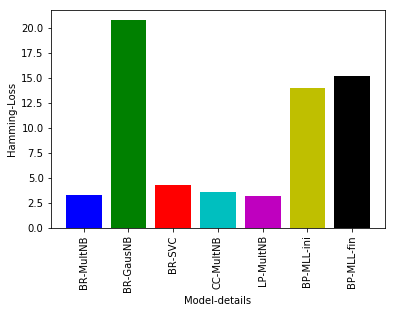

In [5]:
x = ['BR-MultNB','BR-GausNB','BR-SVC','CC-MultNB','LP-MultNB','BP-MLL-ini','BP-MLL-fin']
y = [3.27,20.74,4.26,3.56,3.17,13.96,15.158]
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.ylabel('Hamming-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

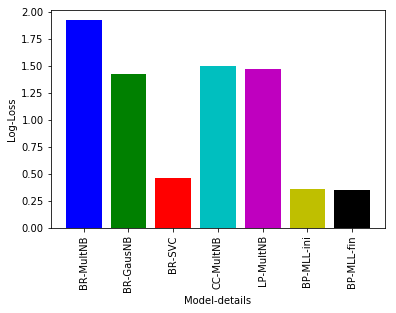

In [6]:
x = ['BR-MultNB','BR-GausNB','BR-SVC','CC-MultNB','LP-MultNB','BP-MLL-ini','BP-MLL-fin']
y = [1.92,1.422,0.46,1.5,1.47,0.36,0.35]
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
plt.ylabel('Log-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i], color=next(colors))
plt.show()

- While showing among the best problem transformation method models, hamming-loss was considered (this is because for BP-MLL neural network we had to round the final results to get the hamming-loss because of the output being multivalued probabilities)
- But while chosing among the best Adaptation Algorithm model, log loss was preferred.